In [39]:
from transformers import AutoTokenizer
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from datasets import load_dataset,ClassLabel,Value,concatenate_datasets,Features,Array2D
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [21]:
# Set device
device = "cpu"
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda_is_available():
    device = "cuda"
device = torch.device(device)

#Set Parameters for creating the Dataset
num_workers = 0
train_split = 0.7
val_split = 0.15
test_split= 0.15
seed = 42

# Set hyperparameters for training
epochs=100
batch_size = 64
learning_rate = 0.001
weight_decay = 0.001 #0.0001
patience = 5

In [23]:

dataset_diffusion_train = load_dataset("poloclub/diffusiondb","2m_first_10k")
dataset_diffusion_test = load_dataset("poloclub/diffusiondb","2m_random_5k")
dataset_imagenette = load_dataset("frgfm/imagenette","160px")

Found cached dataset diffusiondb (/Users/pauladler/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_10k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset diffusiondb (/Users/pauladler/.cache/huggingface/datasets/poloclub___diffusiondb/2m_random_5k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset imagenette (/Users/pauladler/.cache/huggingface/datasets/frgfm___imagenette/160px/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)


  0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
del_col = ['prompt','seed', 'step','cfg','sampler','width','height','user_name','timestamp','image_nsfw', 'prompt_nsfw']

train_db = dataset_diffusion_train["train"]
train_db = train_db.add_column("label",len(train_db) * [0])
train_db = train_db.remove_columns(del_col)

test_db = dataset_diffusion_test["train"]
test_db = test_db.add_column("label",len(test_db) * [0])
test_db = test_db.remove_columns(del_col)

train_I = dataset_imagenette["train"]
train_I = train_I.remove_columns("label")
train_I = train_I.add_column("label",len(train_I) * [1])

test_I = dataset_imagenette["validation"]
test_I = test_I.remove_columns("label")
test_I = test_I.add_column("label",len(test_I) * [1])

data = concatenate_datasets([train_I, train_db, test_I, test_db])

dataset = data.with_transform(transforms)
numtrainsamples = int(len(dataset) * train_split)
numvalsamples = int(len(dataset) * val_split)
numtestsamples = int(len(dataset) * test_split)
if numtrainsamples + numvalsamples + numtestsamples != int(len(dataset)):
    diff = int(len(dataset)) - numtrainsamples - numvalsamples - numtestsamples
    numtrainsamples += diff
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [numtrainsamples, numvalsamples, numtestsamples], generator=torch.Generator().manual_seed(seed))

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

In [22]:
jitter = Compose(
    [ToTensor(),Resize((160,160))]
)


def transforms(examples):
    examples["pixel_values"] = [jitter(image.convert("RGB")) for image in examples["image"]]
    return examples


def collate_fn(examples):
    images, labels = [], []
    for example in examples:
        images.append((example["pixel_values"]))
        labels.append(example["label"])
    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "label": labels}


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.min_model = None

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.min_model = model
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [25]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = torch.nn.Linear(2048, 2)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
stopper = EarlyStopper(patience=patience, min_delta=0)

In [26]:
train_accu, train_losses = [], []

def train(data):
    correct, running_loss, total = 0, 0, 0

    model.train()
    for element in tqdm(data):
        # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss=running_loss/len(data)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    return train_loss


In [27]:
stop = False
eval_losses, eval_accu=[], []

def val(data):
    correct, running_loss, total = 0, 0, 0

    model.eval()
    with torch.no_grad():
      for element in tqdm(data):
          inputs = element["pixel_values"].to(device)
          labels = element["label"].to(device)

        
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

    val_loss=running_loss/len(data)
    accu=100.*correct/total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(val_loss,accu))
    return val_loss



In [28]:
for epoch in range(1,epochs+1):
  print('\nEpoch : %d'%epoch)
  train_loss = train(train_dataloader)
  val_loss = val(val_dataloader)
  if stopper.early_stop(val_loss, model):
    model = stopper.min_model
    break


Epoch : 1


100%|██████████| 311/311 [06:01<00:00,  1.16s/it]


Train Loss: 0.076 | Accuracy: 97.595


100%|██████████| 67/67 [00:48<00:00,  1.40it/s]


Val Loss: 0.258 | Accuracy: 88.002

Epoch : 2


100%|██████████| 311/311 [06:08<00:00,  1.18s/it]


Train Loss: 0.039 | Accuracy: 99.084


100%|██████████| 67/67 [00:47<00:00,  1.40it/s]


Val Loss: 0.074 | Accuracy: 96.877

Epoch : 3


100%|██████████| 311/311 [06:09<00:00,  1.19s/it]


Train Loss: 0.046 | Accuracy: 98.999


100%|██████████| 67/67 [00:47<00:00,  1.41it/s]


Val Loss: 0.072 | Accuracy: 97.253

Epoch : 4


100%|██████████| 311/311 [06:09<00:00,  1.19s/it]


Train Loss: 0.024 | Accuracy: 99.316


100%|██████████| 67/67 [00:47<00:00,  1.41it/s]


Val Loss: 0.115 | Accuracy: 95.468

Epoch : 5


100%|██████████| 311/311 [06:08<00:00,  1.18s/it]


Train Loss: 0.011 | Accuracy: 99.718


100%|██████████| 67/67 [00:47<00:00,  1.41it/s]


Val Loss: 0.014 | Accuracy: 99.765

Epoch : 6


100%|██████████| 311/311 [06:08<00:00,  1.18s/it]


Train Loss: 0.015 | Accuracy: 99.567


100%|██████████| 67/67 [00:47<00:00,  1.41it/s]


Val Loss: 0.078 | Accuracy: 97.182

Epoch : 7


100%|██████████| 311/311 [06:10<00:00,  1.19s/it]


Train Loss: 0.013 | Accuracy: 99.653


100%|██████████| 67/67 [00:47<00:00,  1.40it/s]


Val Loss: 0.006 | Accuracy: 99.930

Epoch : 8


100%|██████████| 311/311 [06:11<00:00,  1.19s/it]


Train Loss: 0.021 | Accuracy: 99.316


100%|██████████| 67/67 [00:47<00:00,  1.41it/s]


Val Loss: 0.007 | Accuracy: 99.836

Epoch : 9


100%|██████████| 311/311 [06:09<00:00,  1.19s/it]


Train Loss: 0.012 | Accuracy: 99.633


100%|██████████| 67/67 [00:47<00:00,  1.40it/s]


Val Loss: 11.813 | Accuracy: 53.768

Epoch : 10


100%|██████████| 311/311 [06:11<00:00,  1.19s/it]


Train Loss: 0.010 | Accuracy: 99.673


100%|██████████| 67/67 [00:47<00:00,  1.40it/s]


Val Loss: 0.035 | Accuracy: 98.990

Epoch : 11


100%|██████████| 311/311 [06:10<00:00,  1.19s/it]


Train Loss: 0.011 | Accuracy: 99.663


100%|██████████| 67/67 [00:47<00:00,  1.41it/s]


Val Loss: 0.013 | Accuracy: 99.601

Epoch : 12


100%|██████████| 311/311 [06:09<00:00,  1.19s/it]


Train Loss: 0.013 | Accuracy: 99.598


100%|██████████| 67/67 [00:48<00:00,  1.38it/s]

Val Loss: 0.007 | Accuracy: 99.883


In [49]:
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for element in test_dataloader:
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 99.78868278938718 %


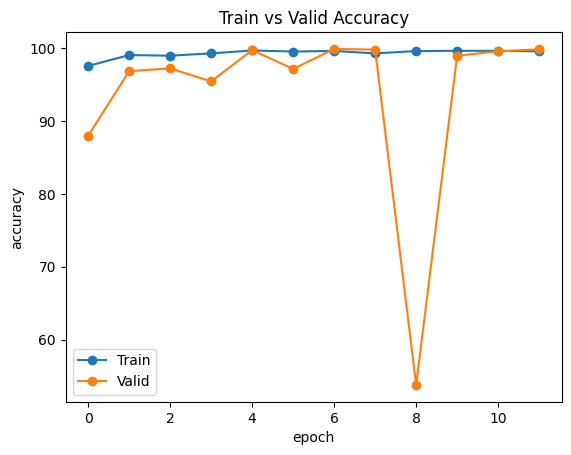

In [30]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

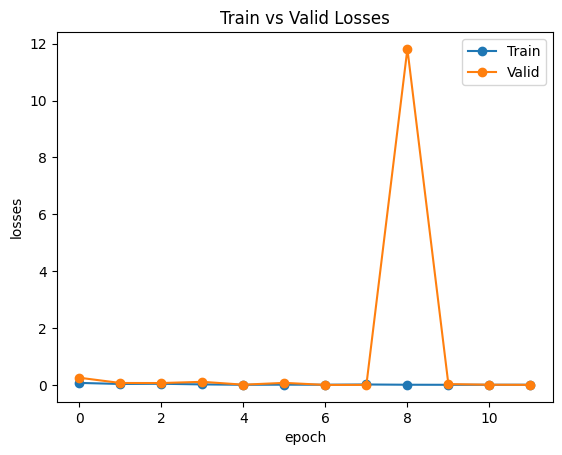

In [31]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [32]:
PATH = './classifier.pth'
torch.save(model.state_dict(), PATH)

In [46]:
from PIL import ImageFile, Image

model = torchvision.models.resnet50()
model.fc = torch.nn.Linear(2048, 2)
model.load_state_dict(torch.load("classifier.pth"))
model.to(device)
model.eval()
image = Image.open('t.jpg')
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)
inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
predicted

tensor([1], device='mps:0')

In [ ]:
image = Image.open('test.jpg')
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
predicted

In [ ]:
image = Image.open('golf.jpg')
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
predicted